## 0 Importing modules

In [1]:
using PyPlot
using DifferentialEquations
using Plots
using PyCall

## 1 Establishing the relationship between neighbors

In [2]:
function neighbors(n, i, j) ###--> the function in this form is suitable for 1st and 2nd neighbors
    # returns a look-up table of neighbors based on:
    # n - neighborhood level (e.g. if n=4 --> the 4th neighbors)
    # i,j - cordinates of element whose neigbors we want to find
    
    #empty lists for di (neighbors for the i-coordinate) and dj (neighbors for the j-coordinate)
    di_n = Array{Float64}[]
    dj_n = Array{Float64}[]
    

    #1. basic elements ##basic elements are also called primary (I gave them a new name :))
    if iseven(i)==true
        push!(di_n,[0,0,-1,1,-1,1])
        push!(dj_n,[-n,n,-n,-n,n-1,n-1])
    else
        push!(di_n,[0,0,-1,1,-1,1])
        push!(dj_n,[-n,n,n,n,1-n,1-n])
    end

    if n > 2
        push!(di_n,[-2,2])
        push!(dj_n,[1-n,1-n])
    end
    
    #2.symmetric elements (starting from n=2)
    if n > 1
        if iseven(n)
            for coord = -(n/2):(n/2)
                push!(di_n,[n,-n])
                push!(dj_n,[coord,coord])
            end       
        else
            if iseven(i) 
                for coord = -ceil(n/2):floor(n/2)
                    push!(di_n,[-n,n])
                    push!(dj_n,[coord,coord])
                end
            else
                for coord = -floor(n/2):ceil(n/2)
                    push!(di_n,[n,-n])
                    push!(dj_n,[coord,coord])
                end   
            end
        end
    end
    
    
    di_n = collect(Iterators.flatten(di_n))
    dj_n = collect(Iterators.flatten(dj_n))
    

    #print("\n")
    print(di_n)
    #print("\n")
    print(dj_n)
    #return di_n, dj_n to return the algorithm not the precise coordinates
    
    i_coord_list = [x + i for x in di_n]
    j_coord_list = [x + j for x in dj_n]
    
    
    #print("\n")
    #print("\n")
    #print("\n")
    #print(size(i_coord_list))
    #print("\n")
    #print(i_coord_list)
    #print("\n")
    #print(j_coord_list)
    
    return i_coord_list, j_coord_list

end
    
    

neighbors (generic function with 1 method)

In [3]:
#neighbors(1,2,2)

In [4]:
#neighbors(2,1,1)

## 2 Converting hexagonal coordinates to Cartesian

In [5]:
"""
Function that transforms the coordinates from the hexagonal system to the Cartesian ones.
taking into account whether the size of the system N is odd or even. If floor(N/2) is odd 
or even matters when it comes to shifting the indices in the cartesian plane
"""

function coordinate_change(coord, N) ##N is the size of the grid, not the order of neighborhood
    dist = h = 1

    if iseven(Int(floor(N/2)))==true
        if coord[1]%2 == 0
            x,y = coord[1],coord[2]
        else
            x = coord[1]
            y = coord[2] + (dist/2)
        end
    else
        if coord[1]%2 == 0
            x,y = coord[1],coord[2]
        else
            x = coord[1]
            y = coord[2] - (dist/2)
    end
    end
    return x,y
end

coordinate_change (generic function with 1 method)

# 4 Simulation

### System of equations
$\cfrac{dm_{i}}{dt}  \;\;\;  =  \;\;\;  \alpha_{m}\cfrac{v_{i}}{K_{vm} + v_{i}} \; \cfrac{K_{Mm}^{n}}{K_{Mm}^{n} + M_{i}^{n}} \;\;\; -\;\;\; (d_{m}+\alpha_{v2})m_{i} $

&nbsp;

$\cfrac{dS_{i}}{dt}  \;\;\;  =  \;\;\; \alpha_{S_{0}} \;\;\;+\;\;\;  \alpha_{S}\cfrac{m_{i}^{n}}{K_{mS}^{n} + m_{i}^{n}}  \;\;\; -  \;\;\;  d_{S}S_{i} $

&nbsp;

$\cfrac{dM_{i}}{dt}  \;\;\;  =  \;\;\;  \alpha_{M}\cfrac{I_{i}^{n}}{K_{I}^{n} + I_{i}^{n}}  \;\;\; -  \;\;\;  d_{M}M_{i} $

&nbsp;

$\cfrac{dv_{i}}{dt}  \;\;\;  =  \;\;\;  \alpha_{v1} m_{i}  \;\;\;  +  \;\;\; \sum_{j=1}^{N} D_{j}(v_{j} - v_{i})  \;\;\;  -  \;\;\;  d_{v}v_{i} $

&nbsp;

$\cfrac{dI_{i}}{dt}  \;\;\;  =  \;\;\; \alpha_{I} \cfrac{ m_{i}^{n}}{K_{a}^{n}+m_{i}^{n}} \cfrac{ K_{r}^{n}}{K_{r}^{n}+m_{i}^{n}}    \cfrac{ S_{i}^{n}}{K_{S}^{n}+S_{i}^{n}}\;\;\; +  \;\;\;  \sum_{j=1}^{N} D_{j}(I_{j} - I_{i})  \;\;\; -   \;\;\; d_{I}I_{i} $
&nbsp;

In [6]:
### MODEL
#parameters

#eqn1 - viral RNA
αm = 0.5 #
dm = 0.1 #
KMm = 10 #
n = 10
Kvm = 1 #

#eqn2 - sensor RIG-I
αS0 = 0.1 #
αS = 0.5 #
KmS = 10 #
dS = 0.1 #

#eqn3 - MxA ISG
αM = 0.5 #
KI = 10 #
dM = 0.1 #

#eqn4 - virus
αv = 0.5 #
Dv = 1#1 #
dv = 0.1 #

#eqn5 - interferon
αI = 0.8 #
Ka = 2 #
Kr = 4 #
KS = 2#5,10 doesnt work #1 works #
dI = 0.4 #
DI = 5 #
n = 10 #

#number of cells in one side
N = 101

#initial conditions
v0 = zeros(N,N)

v0[Int(ceil(N/2)),Int(ceil(N/2))] = 0.01 #conclusion: a little virus goes a long way
# 2. initial conditions for IFN
i0 = zeros(N,N)
#3. initial conditions for MxA
M0 = zeros(N,N)
#4. initial conditions for viral mRNA
m0 = zeros(N,N)
#5. initial conditions for sensor RIG-I
S0 = zeros(N,N)
#vector of init. cond.
u0 = cat(m0, S0, M0, v0, i0, dims = 3)


function f!(du,u,p,t)
    
    du[:,:,1].= ((αm.*u[:,:,4])./(Kvm .+ u[:,:,4])).* (KMm^n ./ (KMm^n .+ u[:,:,3].^n)) .-dm*u[:,:,1] 
    
    du[:,:,2].= αS0.+ ((αS.*u[:,:,1].^n) ./ (KmS^n .+ u[:,:,1].^n)) .-dS*u[:,:,2]
    
    du[:,:,3].= ((αM.*u[:,:,5].^n) ./ (KI^n .+ u[:,:,5].^n)) .-dM*u[:,:,3]
    
    
    #---------------------------------------------------
    #VIRUS
    vup = circshift(u[:,:,4],(1,0))
    vdown = circshift(u[:,:,4],(-1,0))
    
    vleft_up_even = circshift(u[:,:,4],(0,1))
    vleft_down_even = circshift(u[:,:,4],(-1,1))
    vright_up_even = circshift(u[:,:,4],(0,-1))
    vright_down_even = circshift(u[:,:,4],(-1,-1))
    
    vleft_up_odd = circshift(u[:,:,4],(1,1))
    vleft_down_odd = circshift(u[:,:,4],(0,1))
    vright_up_odd = circshift(u[:,:,4],(1,-1))
    vright_down_odd = circshift(u[:,:,4],(0,-1))
    
    #boundary conditions        
    vleft_up = zeros(N,2) #how to initialize a nxn matrix in julia
    vleft_down = zeros(N,2)
    vright_up = zeros(N,2)
    vright_down = zeros(N,2)
    for i=1:N
        if isodd(i)
        vleft_up = hcat(vleft_up,vleft_up_odd[:,i])
        vleft_down = hcat(vleft_down,vleft_down_odd[:,i])
        vright_up = hcat(vright_up,vright_up_odd[:,i])
        vright_down = hcat(vright_down,vright_down_odd[:,i])
        else
        vleft_up = hcat(vleft_up,vleft_up_even[:,i])
        vleft_down = hcat(vleft_down,vleft_down_even[:,i])
        vright_up = hcat(vright_up,vright_up_even[:,i])
        vright_down = hcat(vright_down,vright_down_even[:,i])
        end
    end

    vleft_up = vleft_up[:, setdiff(1:end, (1,2))]
    vleft_down = vleft_down[:, setdiff(1:end, (1,2))]
    vright_up = vright_up[:, setdiff(1:end, (1,2))]
    vright_down = vright_down[:, setdiff(1:end, (1,2))]
    
    #INTERFERON
    iup = circshift(u[:,:,5],(1,0))
    idown = circshift(u[:,:,5],(-1,0))
    
    ileft_up_even = circshift(u[:,:,5],(0,1))
    ileft_down_even = circshift(u[:,:,5],(-1,1))
    iright_up_even = circshift(u[:,:,5],(0,-1))
    iright_down_even = circshift(u[:,:,5],(-1,-1))
    
    ileft_up_odd = circshift(u[:,:,5],(1,1))
    ileft_down_odd = circshift(u[:,:,5],(0,1))
    iright_up_odd = circshift(u[:,:,5],(1,-1))
    iright_down_odd = circshift(u[:,:,5],(0,-1))
    
    
    ileft_up = zeros(N,2) #how to initialize a nxn matrix in julia
    ileft_down = zeros(N,2)
    iright_up = zeros(N,2)
    iright_down = zeros(N,2)
    for i=1:N
        if isodd(i)
        ileft_up = hcat(ileft_up,ileft_up_odd[:,i])
        ileft_down = hcat(ileft_down,ileft_down_odd[:,i])
        iright_up = hcat(iright_up,iright_up_odd[:,i])
        iright_down = hcat(iright_down,iright_down_odd[:,i])
        else
        ileft_up = hcat(ileft_up,ileft_up_even[:,i])
        ileft_down = hcat(ileft_down,ileft_down_even[:,i])
        iright_up = hcat(iright_up,iright_up_even[:,i])
        iright_down = hcat(iright_down,iright_down_even[:,i])
        end
    end
    ileft_up = ileft_up[:, setdiff(1:end, (1,2))]
    ileft_down = ileft_down[:, setdiff(1:end, (1,2))]
    iright_up = iright_up[:, setdiff(1:end, (1,2))]
    iright_down = iright_down[:, setdiff(1:end, (1,2))]
    #-------------------------------------------------------
    
    
    du[:,:,4] .= αv*u[:,:,1] .+ Dv.*(vleft_up+vleft_down+vright_up+vright_down+vup+vdown .- 6*u[:,:,4]) .- dv*u[:,:,4]
            
    du[:,:,5] .= αI*(u[:,:,1].^n ./ (Ka^n .+ u[:,:,1].^n)) .* (1 ./ (1.0 .+ (u[:,:,1]./Kr).^n)) .* (u[:,:,2].^n ./ (KS^n .+ u[:,:,2].^n))  .+ DI.*(ileft_up+ileft_down+iright_up+iright_down+iup+idown .- 6*u[:,:,5]) .- dI*u[:,:,5]    
    
    return du
end


tspan = (0.0,150.0)
prob = ODEProblem(f!,u0,tspan)
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1900-element Vector{Float64}:
   0.0
   9.000871181585391e-5
   0.000990095829974393
   0.009990967011559783
   0.05635919528897059
   0.13364703726364302
   0.2294174687830163
   0.35758559618601493
   0.5173022767792206
   0.7228273367311346
   0.9832440918701221
   1.324677659446388
   1.7741217462120527
   ⋮
 149.18334136752114
 149.26059607440672
 149.33785078845523
 149.41510549431752
 149.49236019711
 149.56961489171627
 149.64686959348546
 149.72412430241758
 149.8013790031635
 149.87863369572324
 149.9558883903295
 150.0
u: 1900-element Vector{Array{Float64, 3}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0

## 5 Plotting

### 5.1 Hexagonal grid

In [10]:
"""
Function that computes the hexagonal grid coordinates based on the 
domain of simulation N and converts them to the Cartesian space.
"""
function hexagonal_grid(N)
    tuple_list = Vector{Tuple{Float64, Float64}}()
    for i = -Int(floor(N/2)):Int(floor(N/2))
        for j = -Int(floor(N/2)):Int(floor(N/2))
            push!(tuple_list,coordinate_change((i,j),N))
        end
    
    end

    tuples_unzipped = map(x->getfield.(tuple_list, x), fieldnames(eltype(tuple_list)))
    x_coord = tuples_unzipped[1]
    y_coord = tuples_unzipped[2]
    
    return tuple_list, x_coord, y_coord

end


hexagonal_grid

In [11]:
tuple_list, x_coord, y_coord = hexagonal_grid(N)

([(-50.0, -50.0), (-50.0, -49.0), (-50.0, -48.0), (-50.0, -47.0), (-50.0, -46.0), (-50.0, -45.0), (-50.0, -44.0), (-50.0, -43.0), (-50.0, -42.0), (-50.0, -41.0)  …  (50.0, 41.0), (50.0, 42.0), (50.0, 43.0), (50.0, 44.0), (50.0, 45.0), (50.0, 46.0), (50.0, 47.0), (50.0, 48.0), (50.0, 49.0), (50.0, 50.0)], [-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0  …  50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0], [-50.0, -49.0, -48.0, -47.0, -46.0, -45.0, -44.0, -43.0, -42.0, -41.0  …  41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0])

In [12]:
tuple_list

10201-element Vector{Tuple{Float64, Float64}}:
 (-50.0, -50.0)
 (-50.0, -49.0)
 (-50.0, -48.0)
 (-50.0, -47.0)
 (-50.0, -46.0)
 (-50.0, -45.0)
 (-50.0, -44.0)
 (-50.0, -43.0)
 (-50.0, -42.0)
 (-50.0, -41.0)
 (-50.0, -40.0)
 (-50.0, -39.0)
 (-50.0, -38.0)
 ⋮
 (50.0, 39.0)
 (50.0, 40.0)
 (50.0, 41.0)
 (50.0, 42.0)
 (50.0, 43.0)
 (50.0, 44.0)
 (50.0, 45.0)
 (50.0, 46.0)
 (50.0, 47.0)
 (50.0, 48.0)
 (50.0, 49.0)
 (50.0, 50.0)

### 5.2 Concentration

In [13]:
colors_v = reshape(sol[350][:,:,4],length(sol[8][:,:,4]),1)

10201×1 Matrix{Float64}:
 1.26263035683863e-13
 1.2924973025293596e-13
 1.7786491761286872e-13
 2.877720761499798e-13
 4.931890320162975e-13
 8.559860603876844e-13
 1.48150817898677e-12
 2.5443557114051273e-12
 4.329096943713124e-12
 7.293269865081626e-12
 1.2163261581828229e-11
 2.007794804826888e-11
 3.280052952988363e-11
 ⋮
 4.5343336384755884e-11
 2.8171742691353322e-11
 1.7329759185445834e-11
 1.0555982269948156e-11
 6.367725492061079e-12
 3.804655729551945e-12
 2.2521850109119084e-12
 1.3216529729306062e-12
 7.702476644535527e-13
 4.4829248134470867e-13
 2.651221454443109e-13
 1.674677902457146e-13

In [14]:
colors_v = reshape(sol[680][:,:,4],length(sol[8][:,:,4]),1)

10201×1 Matrix{Float64}:
 0.00011964072435513109
 0.00011262821563631071
 0.0001234853872751309
 0.00015378881710808502
 0.00020761968770849966
 0.0002919685618173141
 0.00041739578157486
 0.0005989765494909654
 0.000857566275304638
 0.0012214241747670932
 0.001728229402919381
 0.0024275117642049994
 0.0033834955169401546
 ⋮
 0.0056639402711019075
 0.004134289715334747
 0.002995134057928467
 0.002154091842383494
 0.0015384000827581249
 0.0010914869599081662
 0.0007699188300872439
 0.0005407688395604503
 0.0003794132423349912
 0.00026773540531584416
 0.0001927033807480312
 0.00014528185995308035

### 5.3 Virus

In [15]:
colors_v = reshape(sol[200][:,:,4],length(sol[8][:,:,4]),1)

10201×1 Matrix{Float64}:
 1.2471029587686676e-20
 1.5437657515068666e-20
 2.895791217851125e-20
 6.156130453595101e-20
 1.3314336775264288e-19
 2.8579041993823225e-19
 6.057389357830204e-19
 1.2663700253470152e-18
 2.6106057660125973e-18
 5.30593253880133e-18
 1.0630858677963405e-17
 2.0994679543120845e-17
 4.086317651439208e-17
 ⋮
 4.516348281356099e-17
 2.3443190438666032e-17
 1.19992525041336e-17
 6.056991831925093e-18
 3.0156561884721114e-18
 1.4811063717783338e-18
 7.1768656006961725e-19
 3.431869739529401e-19
 1.6206114056653232e-19
 7.580826187416349e-20
 3.5658664445817385e-20
 1.808017393102289e-20

In [16]:
maximum(sol[680][:,:,4]) 

15.935502655053263

In [17]:
colors_v_norm = colors_v/maximum(sol[680][:,:,4])

10201×1 Matrix{Float64}:
 7.8259405163677235e-22
 9.687587426163349e-22
 1.8171947760511014e-21
 3.8631542329434755e-21
 8.355140759266992e-21
 1.7934195495716355e-20
 3.8011912701789563e-20
 7.946847066951101e-20
 1.638232456498481e-19
 3.329629854580571e-19
 6.671178756066588e-19
 1.3174783373691247e-18
 2.5642853820763584e-18
 ⋮
 2.8341423418632688e-18
 1.4711296496964924e-18
 7.529886420199335e-19
 3.800941810896927e-19
 1.8924135960755684e-19
 9.294381255734435e-20
 4.5036957766878704e-20
 2.1535999295517233e-20
 1.0169816671276545e-20
 4.757193012052503e-21
 2.237686831579785e-21
 1.1345844760842568e-21

In [18]:
colors_v = reshape(sol[200][:,:,4],length(sol[8][:,:,4]),1)

10201×1 Matrix{Float64}:
 1.2471029587686676e-20
 1.5437657515068666e-20
 2.895791217851125e-20
 6.156130453595101e-20
 1.3314336775264288e-19
 2.8579041993823225e-19
 6.057389357830204e-19
 1.2663700253470152e-18
 2.6106057660125973e-18
 5.30593253880133e-18
 1.0630858677963405e-17
 2.0994679543120845e-17
 4.086317651439208e-17
 ⋮
 4.516348281356099e-17
 2.3443190438666032e-17
 1.19992525041336e-17
 6.056991831925093e-18
 3.0156561884721114e-18
 1.4811063717783338e-18
 7.1768656006961725e-19
 3.431869739529401e-19
 1.6206114056653232e-19
 7.580826187416349e-20
 3.5658664445817385e-20
 1.808017393102289e-20

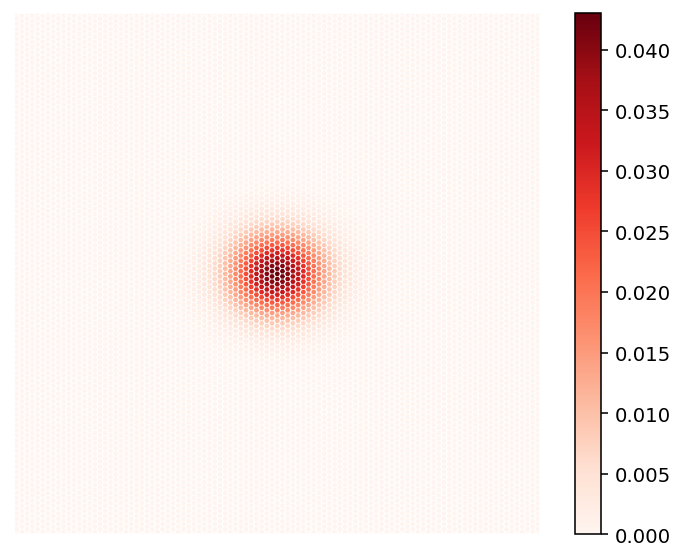

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000BAA59F00>

In [19]:
vmin = -50#-50
vmax = 50#50
fig, ax = PyPlot.subplots(dpi=141)

ax.set_xlim(vmin-0.5, vmax+0.5)
ax.set_ylim(vmin, vmax)

ax.set_aspect(1)
fig.canvas.draw()
s =((ax.get_window_extent().width  / (vmax-vmin+1.) * 72/fig.dpi) ^ 2)
#s = ((ax.get_window_extent().width  ))#/ (vmax-vmin+1.) * 72./fig.dpi) ** 2)
virus = ax.scatter(x_coord, y_coord,  c = colors_v, marker=:H, s = s, linewidth=0, edgecolor = "black", cmap="Reds")
plt.tick_params(left=false,
                bottom=false,
                labelleft=false,
                labelbottom=false)
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white") 
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
#plt.savefig("virus_400")
#plt.colorbar()
fig.colorbar(virus)
#PyPlot.colorbar()

### 5.4 Interferon

In [20]:
colors_i = reshape(sol[600][:,:,5],length(sol[8][:,:,5]),1)

10201×1 Matrix{Float64}:
  6.222334342368639e-10
 -3.56915525650859e-9
  7.584642339885554e-9
 -1.868341341515339e-9
 -2.2790472735182663e-9
  9.761046697191186e-9
 -3.5260018102205946e-9
 -1.6847416988163821e-10
  1.3374116410203257e-8
 -3.81488562378263e-9
  3.5748664676054175e-9
  1.946876922615842e-8
 -1.4174779852967361e-9
  ⋮
  2.7223259833389005e-8
  2.8367688385039174e-9
  1.3036715593188816e-8
  1.561542801389902e-8
 -2.3275819128609278e-9
  8.20517043368702e-9
  8.563019173997822e-9
 -4.130004185139212e-9
  6.45947316161867e-9
  3.939226277600271e-9
 -4.2691220037861836e-9
  6.45383438306451e-9

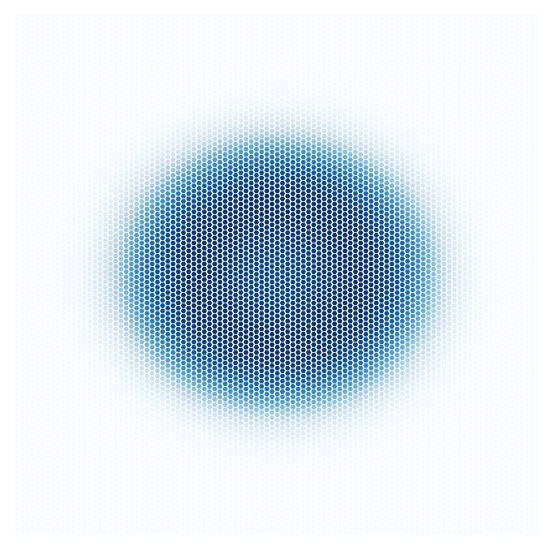

In [21]:
vmin = -50
vmax = 50
fig, ax = PyPlot.subplots(dpi=141)

ax.set_xlim(vmin-0.5, vmax+0.5)
ax.set_ylim(vmin, vmax)

ax.set_aspect(1)
fig.canvas.draw()
s =((ax.get_window_extent().width  / (vmax-vmin+1.) * 72/fig.dpi) ^ 2)
#s = ((ax.get_window_extent().width  ))#/ (vmax-vmin+1.) * 72./fig.dpi) ** 2)
ax.scatter(x_coord, y_coord,  c = colors_i, marker=:H, s = s, linewidth=0, edgecolor = "black", cmap="Blues")
plt.tick_params(left=false,
                bottom=false,
                labelleft=false,
                labelbottom=false)
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white") 
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
#ax.invert_yaxis()
#plt.savefig("interferon_350")
#PyPlot.colorbar()

### 5.5 Plotting with scale

In [22]:
max_val_v = maximum(maximum.(Data_v[680]))
min_val_v = minimum(minimum.(Data_v[680]))


vmin = -50
vmax = 50
fig, ax = PyPlot.subplots(dpi=141)#, figsize = (4,4))

ax.set_xlim(vmin-0.5, vmax+0.5)
ax.set_ylim(vmin-0.5, vmax+0.5)

ax.set_aspect(1)
fig.canvas.draw()
s =((ax.get_window_extent().width  / (vmax-vmin+1.) * 82/fig.dpi) ^ 2)
#s = ((ax.get_window_extent().width  ))#/ (vmax-vmin+1.) * 72./fig.dpi) ** 2)
virus = ax.scatter(x_coord, y_coord,  c = Data_v[650], marker=:H, s = s, linewidth=0, edgecolor = "black", cmap="Reds", vmax = max_val_v, vmin = min_val_v)
plt.tick_params(left=false,
                bottom=false,
                labelleft=false,
                labelbottom=false)
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white") 
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
#plt.savefig("interferon_2____")
#PyPlot.colorbar()
#ax.set_clim(vmin=min_val_v, vmax=max_val_v)
#ax.set_title("Virus")
#axes[1].set_xlabel("Distance, x")
#axes[1].set_ylabel("Distance, y")
cbar = fig.colorbar(virus)
cbar.ax.tick_params(labelsize=14)  # Adjust the font size as desired

#fig.colorbar(img1, ax = axes[1], shrink = 1, extend="both")
#time = ax.text(0.5,0.5, "frame = 0", ha="left", va="top")
plt.savefig("virus_final_650.png", dpi = 600)

LoadError: UndefVarError: Data_v not defined

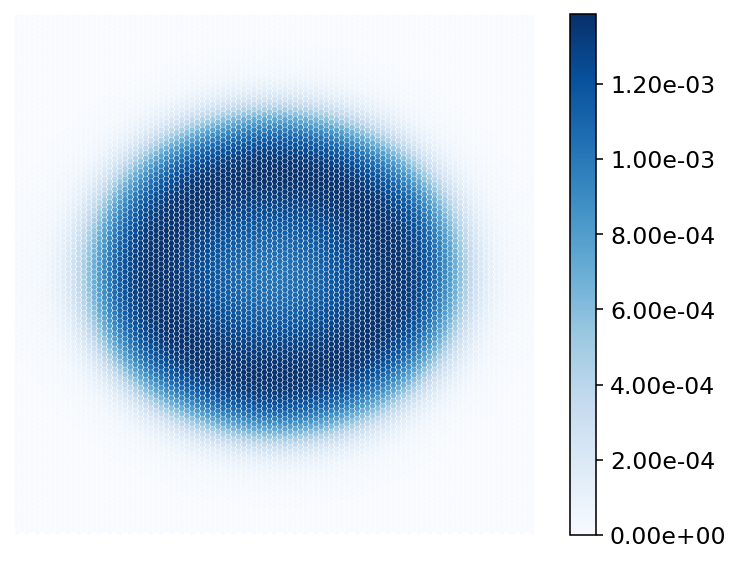

In [122]:
max_val_i = maximum(maximum.(Data_i[680]))
min_val_i = minimum(minimum.(Data_i[680]))


vmin = -50
vmax = 50
fig, ax = PyPlot.subplots(dpi=141)#, figsize = (4,4))

ax.set_xlim(vmin-0.5, vmax+0.5)
ax.set_ylim(vmin-0.5, vmax+0.5)

ax.set_aspect(1)
fig.canvas.draw()
s =((ax.get_window_extent().width  / (vmax-vmin+1.) * 82/fig.dpi) ^ 2)
#s = ((ax.get_window_extent().width  ))#/ (vmax-vmin+1.) * 72./fig.dpi) ** 2)
ifn = ax.scatter(x_coord, y_coord,  c = Data_i[650], marker=:H, s = s, linewidth=0, edgecolor = "black", cmap="Blues", vmax = max_val_i, vmin = min_val_i)
plt.tick_params(left=false,
                bottom=false,
                labelleft=false,
                labelbottom=false)
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white") 
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
#plt.savefig("interferon_2____")
#PyPlot.colorbar()
#ax.set_clim(vmin=min_val_v, vmax=max_val_v)
#ax.set_title("Interferon")
#axes[1].set_xlabel("Distance, x")
#axes[1].set_ylabel("Distance, y")

cbar = fig.colorbar(ifn, format="%4.2e")
cbar.ax.tick_params(labelsize=12)  # Adjust the font size as desired

#fig.colorbar(img1, ax = axes[1], shrink = 1, extend="both")
#time = ax.text(0.5,0.5, "frame = 0", ha="left", va="top")
plt.savefig("ifn_final_650.png", dpi = 600)